In [6]:
import numpy as np
import pandas as pd

test_file = "/home/richard/projects/mesh-bench/results/01_http_max_throughput/http_baseline_MAX_0_1_2022-06-20T08:32:57Z.json"

In [7]:
s = pd.read_json(test_file, typ="series")

# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "RequestedDuration",
    "ActualQPS",
    "ActualDuration",
    "DurationHistogram",
]

s = s[required_cols]

# Extract nested columns in 'DurationHistogram'
for key, val in s["DurationHistogram"].items():
    s[key] = val
s = s.drop(["DurationHistogram", "Percentiles"])


s


StartTime                               2022-06-20T08:32:59.487539804Z
RequestedQPS                                                       max
RequestedDuration                                                15m0s
ActualQPS                                                    8746.6817
ActualDuration                                            900002111624
Count                                                          7872032
Min                                                           0.000047
Max                                                            0.16879
Sum                                                       28795.839311
Avg                                                           0.003658
StdDev                                                        0.003416
Data                 [{'Start': 4.7225e-05, 'End': 0.0001, 'Percent...
dtype: object

In [8]:
# fortio reports in seconds, convert to miliseconds
multiplier = 1000

s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

# Construct Histogram Bins, Counts and Percentiles

data = s["Data"]


s["counts"] = [x["Count"] for x in data]
s["percentages"] = [x["Percent"] for x in data]

# Bins (default pd.cut function makes them as categoricals of intervals)
# https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
# https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
s["bins"] = [x.left for x in s["categories"]]
s["bins"].append(s["categories"][-1].right)

s = s.drop("Data")
s

StartTime                               2022-06-20T08:32:59.487539804Z
RequestedQPS                                                       max
RequestedDuration                                                15m0s
ActualQPS                                                    8746.6817
ActualDuration                                            900002111624
Count                                                          7872032
Min                                                           0.047225
Max                                                          168.79017
Sum                                                    28795839.311071
Avg                                                           3.657993
StdDev                                                        0.003416
counts               [25198, 92183, 97250, 100720, 104478, 110855, ...
percentages          [0.32009524351527, 1.491114365388758, 2.726500...
categories           [(0.047225, 0.1], (0.1, 0.2], (0.2, 0.30000000...
bins  

In [9]:
# bins = s["bins"]

# dir(bins[0])
# bins[0].left
# # bins[0].right

# b = [x.left for x in bins]
# b.append(bins[-1].right)
# b


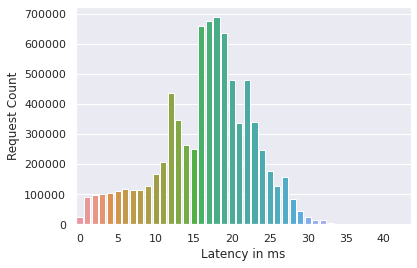

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="darkgrid")


fig, ax = plt.subplots()
sns.barplot(data=s, x=s["bins"][:-1], y="counts")


# ax.set_xticks(range(1, 11))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency in ms")

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

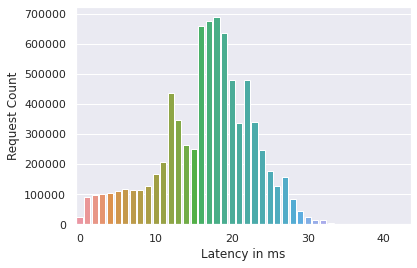

In [17]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()
sns.barplot(data=s, x="categories", y="counts")


# ax.set_xticks(range(1, 11))

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency in ms")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))



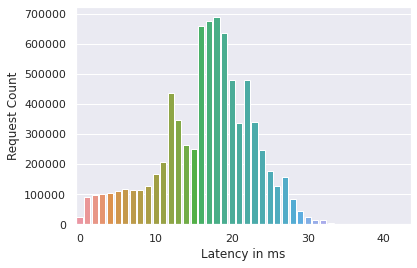

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()
sns.barplot(x=s["bins"][1:], y=s["counts"])



# ax.set_xticks(range(1, 11))

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency in ms")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))



/home/richard/.local/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


AttributeError: 'AxesSubplot' object has no attribute 'set_xlddim'

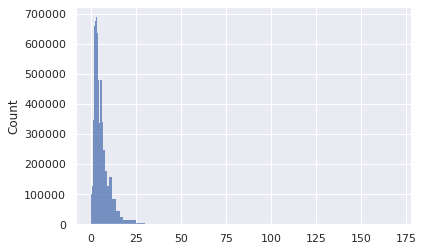

In [49]:

s
fig, ax = plt.subplots()

binedges = np.array(s["bins"])
weights = np.array(s["counts"])
x = (binedges[1:] + binedges[:-1]) / 2.0
# ax.hist(x, bins=binedges, weights=weights)

sns.histplot(data=s, x=x, weights=weights, bins=binedges)

ax.set_xlim(left=0)



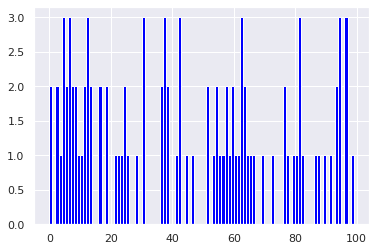

In [23]:
import random
import matplotlib.pyplot as plt
x=[x/1000 for x in random.sample(range(100000),100)]
xbins=range(0,len(x))
plt.hist(x, bins=xbins, color='blue')
plt.show()

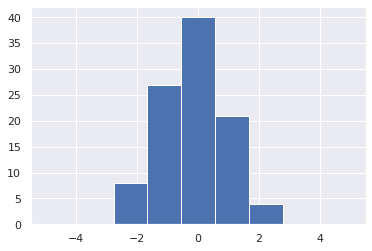

In [26]:
import numpy
import matplotlib.pyplot as plt

def plot_binned_data(axes, binedges, data,
               *args, **kwargs):
    #The dataset values are the bin centres
    x = (binedges[1:] + binedges[:-1]) / 2.0
    #The weights are the y-values of the input binned data
    weights = data
    return axes.hist(x, bins=binedges, weights=weights,
               *args, **kwargs)

#Create a dataset
dataset = numpy.random.normal(size=100)
#Bin the dataset
binedges = numpy.linspace(-5.0, 5.0, num=10)
y, binedges = numpy.histogram(dataset, binedges)

#Plot the dataset
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot_binned_data(ax, binedges, y)
plt.show()

In [35]:

#Create a dataset
dataset = numpy.random.normal(size=100)
#Bin the dataset
binedges = numpy.linspace(-5.0, 5.0, num=10)
y, binedges = numpy.histogram(dataset, binedges)
print(len(y))
print(len(binedges))

9
10
